LSTM model: LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)>
Epoch [100/10000], loss:0.00106
Epoch [200/10000], loss:0.00032
Epoch [300/10000], loss:0.00023
Epoch [400/10000], loss:0.00017
Epoch [500/10000], loss:0.00015
Epoch [600/10000], loss:0.00015
Epoch [700/10000], loss:0.00013
Epoch [800/10000], loss:0.00013
Epoch [900/10000], loss:0.00012
Epoch [1000/10000], loss:0.00012
Epoch [1100/10000], loss:0.00013
Epoch [1200/10000], loss:0.00011
Epoch [1300/10000], loss:0.00011
Epoch [1400/10000], loss:0.00011
Epoch [1500/10000], loss:0.00013
Epoch [1549/10000], loss:0.00010
The loss value is reached


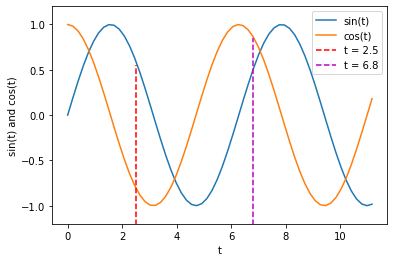

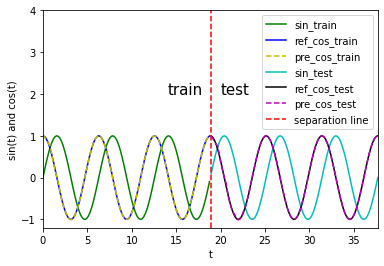

In [7]:
# -*- coding:UTF-8 -*-
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# define LSTM NN
class LstmRNN(nn.Module):
    """
        Parameters:
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
        
    def forward(self, _x):
        x, _ = self.lstm(_x)
        s, b, h = x.shape # (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.forwardCalculation(x)
        x = x.view(s, b, -1)
        return x
    
if __name__ == '__main__':
    # create database
    data_len = 200
    t = np.linspace(0, 12*np.pi, data_len)
    sin_t = np.sin(t)
    cos_t = np.cos(t)
    
    dataset = np.zeros((data_len, 2))
    dataset[:,0] = sin_t
    dataset[:,1] = cos_t
    dataset = dataset.astype('float32')
    
    # plot 
    plt.figure()
    plt.plot(t[0:60], dataset[0:60,0], label='sin(t)')
    plt.plot(t[0:60], dataset[0:60, 1], label='cos(t)')
    plt.plot([2.5, 2.5], [-1.3, 0.55], 'r--', label='t = 2.5')
    plt.plot([6.8, 6.8], [-1.3, 0.85], 'm--', label='t = 6.8')
    plt.xlabel('t')
    plt.ylim(-1.2, 1.2)
    plt.ylabel('sin(t) and cos(t)')
    plt.legend(loc='upper right')
    
    # split data
    train_data_ratio = 0.5
    train_data_len = int(data_len * train_data_ratio)
    train_x = dataset[:train_data_len, 0]
    train_y = dataset[:train_data_len, 1]
    INPUT_FEATURES_NUM = 1
    OUTPUT_FEATURES_NUM = 1
    t_for_training = t[:train_data_len]
    
    test_x = dataset[train_data_len:, 0]
    test_y = dataset[train_data_len:, 1]
    t_for_testing = t[train_data_len:]
    
    ############### train ##############
    train_x_tensor = train_x.reshape(-1, 5, INPUT_FEATURES_NUM)
    train_y_tensor = train_y.reshape(-1, 5, OUTPUT_FEATURES_NUM)
    
    train_x_tensor = torch.from_numpy(train_x_tensor)
    train_y_tensor = torch.from_numpy(train_y_tensor)
    
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 16, output_size=OUTPUT_FEATURES_NUM, num_layers=1)
    print('LSTM model:', lstm_model)
    print('model.parameters:', lstm_model.parameters)
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
    
    max_epochs = 10000
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if loss.item() < 1e-4:
            print('Epoch [{}/{}], loss:{:.5f}'.format(epoch+1, max_epochs, loss))
            print('The loss value is reached')
            break
        elif (epoch+1) % 100 == 0:
            print('Epoch [{}/{}], loss:{:.5f}'.format(epoch+1, max_epochs, loss))
            
    predictive_y_for_training = lstm_model(train_x_tensor)
    predictive_y_for_training = predictive_y_for_training.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
    
    torch.save(lstm_model.state_dict(), 'model_params.pkl')
    
    lstm_model = lstm_model.eval()
    
    test_x_tensor = test_x.reshape(-1, 5, INPUT_FEATURES_NUM)
    test_x_tensor = torch.from_numpy(test_x_tensor)
    
    predictive_y_for_testing = lstm_model(test_x_tensor)
    predictive_y_for_testing = predictive_y_for_testing.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
    
    # plot
    plt.figure()
    plt.plot(t_for_training, train_x, 'g', label='sin_train')
    plt.plot(t_for_training, train_y, 'b', label='ref_cos_train')
    plt.plot(t_for_training, predictive_y_for_training, 'y--', label='pre_cos_train')
    plt.plot(t_for_testing, test_x, 'c', label='sin_test')
    plt.plot(t_for_testing, test_y, 'k', label='ref_cos_test')
    plt.plot(t_for_testing, predictive_y_for_testing, 'm--', label='pre_cos_test')
    
    plt.plot([t[train_data_len], t[train_data_len]], [-1.2, 4.0], 'r--', label='separation line') # separation line
    
    plt.xlabel('t')
    plt.ylabel('sin(t) and cos(t)')
    plt.xlim(t[0], t[-1])
    plt.ylim(-1.2, 4)
    plt.legend(loc='upper right')
    plt.text(14, 2, 'train', size=15, alpha=1.0)
    plt.text(20, 2, 'test', size=15, alpha=1.0)
    
    plt.show()
    